In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='poster', font_scale=0.9,
            rc={'xtick.major.size': 3,
                'ytick.major.size': 3,
                'xtick.major.width': 1,
                'ytick.major.width': 1,
                'xtick.major.pad': 3.5,
                'ytick.major.pad': 3.5,
                'axes.linewidth': 1,
                'lines.linewidth': 2,
               })

In [3]:
replay_info_ca1 = xr.open_mfdataset(
    '../Processed-Data/*.nc', group='/replay_info_ca1').to_dataframe()

In [4]:
replay_info_mec = xr.open_mfdataset(
    '../Processed-Data/*.nc', group='/replay_info_mec').to_dataframe()

In [5]:
replay_info_ca1_mec = xr.open_mfdataset(
    '../Processed-Data/*.nc', group='/replay_info_ca1_mec').to_dataframe()

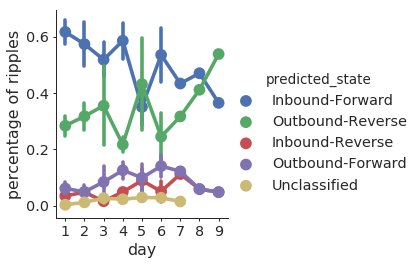

In [6]:
covariate = 'predicted_state'
percentage_of_ripples = (replay_info_ca1
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples', hue=covariate);

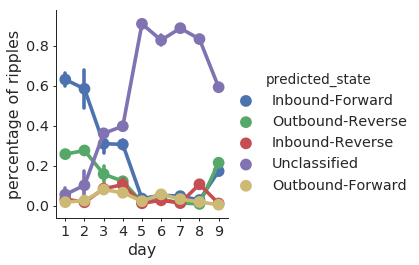

In [7]:
covariate = 'predicted_state'
percentage_of_ripples = (replay_info_mec
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples', hue=covariate);

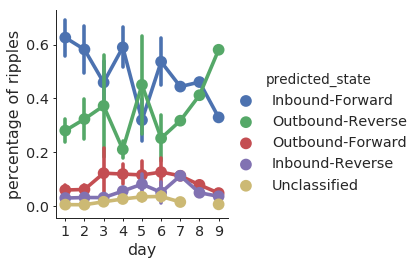

In [8]:
covariate = 'predicted_state'
percentage_of_ripples = (replay_info_ca1_mec
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples', hue=covariate);

Normalized confusion matrix
[[0.37918486 0.04512373 0.0363901  0.17176128 0.36754003]
 [0.23880597 0.02238806 0.04477612 0.09701493 0.59701493]
 [0.30275229 0.03669725 0.05045872 0.09174312 0.51834862]
 [0.30023641 0.03309693 0.02955083 0.16548463 0.47163121]
 [0.27027027 0.08108108 0.02702703 0.05405405 0.56756757]]


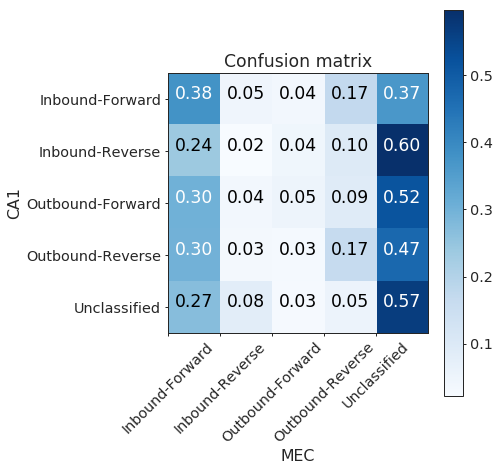

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks - 0.5, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('CA1')
    plt.xlabel('MEC')

classes = sorted(replay_info_ca1.predicted_state.unique())
cnf_matrix_ca1_mec = confusion_matrix(replay_info_ca1.predicted_state, replay_info_mec.predicted_state)
plot_confusion_matrix(cnf_matrix_ca1_mec, classes, normalize=True)

Normalized confusion matrix
[[0.42058824 0.03970588 0.03161765 0.14705882 0.36102941]
 [0.13934426 0.1147541  0.02459016 0.07377049 0.64754098]
 [0.25991189 0.030837   0.11894273 0.08810573 0.50220264]
 [0.26535342 0.02896871 0.02201622 0.20741599 0.47624565]
 [0.16216216 0.10810811 0.02702703 0.08108108 0.62162162]]


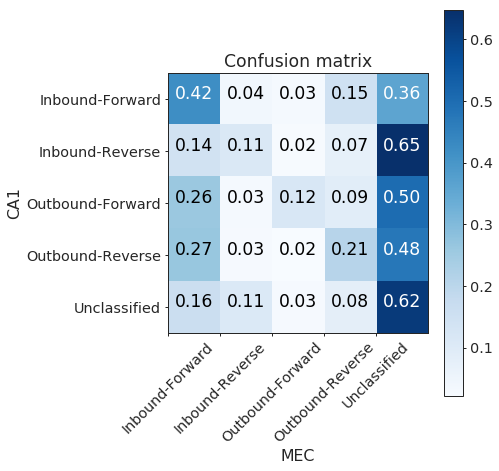

In [10]:
cnf_matrix_ca1_ca1_mec = confusion_matrix(replay_info_ca1_mec.predicted_state, replay_info_mec.predicted_state)
plot_confusion_matrix(cnf_matrix_ca1_ca1_mec, classes, normalize=True)

In [3]:
from matplotlib.colors import LogNorm

def plot_power(group, brain_area, preprocess=None, figsize=(15, 5), vmin=(1/2), vmax=2):
    ds = xr.open_mfdataset('../Processed-Data/*.nc', concat_dim='session', group=group, preprocess=preprocess)
    baseline = ds.isel(time=0).mean(['session', 'tetrode']).power
    raw_measure = ds.mean(['session', 'tetrode']).power
    diff_from_baseline = (ds / ds.isel(time=0)).mean(['session', 'tetrode']).power

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    baseline.plot(ax=axes[0]);
    axes[0].set_title('Baseline Power')
    raw_measure.plot(x='time', y='frequency', ax=axes[1]);
    axes[1].set_title('Raw power')
    diff_from_baseline.plot(
        x='time', y='frequency', ax=axes[2],
        norm=LogNorm(vmin=vmin, vmax=vmax), cmap='RdBu_r',
        vmin=vmin, vmax=vmax, center=0);
    axes[2].set_title('Difference from baseline power')
    
    for ax in axes[1:]:
        ax.axvline(0, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.suptitle(brain_area, fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.85)

In [3]:
from matplotlib.colors import LogNorm

def _plot_distribution(
        ds, dims=None, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975],
        **plot_kwargs):
    alphas = np.array(quantiles)
    alphas[alphas > 0.5] = 1 - alphas[alphas > 0.5]
    alphas = (alphas / 0.5)
    alphas[alphas < 0.2] = 0.2

    for q, alpha in zip(quantiles, alphas):
        ds.quantile(q, dims).plot.line(alpha=alpha, **plot_kwargs)

def plot_power(path, group, brain_area, frequency, figsize=(15, 10),
               vmin=0.5, vmax=2):

    def _preprocess(ds):
        return ds.sel(
            tetrode=ds.tetrode[ds.brain_area == brain_area],
            frequency=frequency
        )
    try:
        ds = xr.open_mfdataset(
            path, concat_dim='session', group=group,
            preprocess=_preprocess, autoclose=True).power.compute()
    except ValueError:
        return
    DIMS = ['session', 'tetrode']

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    _plot_distribution(
        ds.isel(time=0), dims=DIMS, ax=axes[0, 0], color='midnightblue')
    axes[0, 0].set_title('Baseline Power')
    axes[0, 0].set_ylim((ds.min(), ds.max()))

    _plot_distribution(
        ds.isel(time=0), dims=DIMS, ax=axes[1, 0], color='midnightblue')
    axes[1, 0].set_title('Baseline Power')
    axes[1, 0].set_ylim((ds.min(), ds.max()))

    ds.mean(DIMS).plot(x='time', y='frequency', ax=axes[0, 1])
    axes[0, 1].set_title('Raw power')

    _plot_distribution(
        ds.sel(time=0.0, method='backfill'), dims=DIMS,
        ax=axes[1, 1], color='midnightblue')
    axes[1, 1].set_title('Raw power after ripple')
    axes[1, 1].set_ylim((ds.min(), ds.max()))

    (ds / ds.isel(time=0)).mean(DIMS).plot(
        x='time', y='frequency', ax=axes[0, 2],
        norm=LogNorm(vmin=vmin, vmax=vmax), cmap='RdBu_r',
        vmin=vmin, vmax=vmax, center=0)
    axes[0, 2].set_title('Change from baseline power')

    _plot_distribution(
        (ds / ds.isel(time=0)).sel(time=0.0, method='backfill'), dims=DIMS,
        ax=axes[1, 2], color='midnightblue')
    axes[1, 2].set_title('Change after ripple')
    axes[1, 2].axhline(1, color='black', linestyle='--')
    axes[1, 2].set_ylim((vmin, vmax))

    for ax in axes[0, 1:3]:
        ax.axvline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.suptitle(brain_area, fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.90)

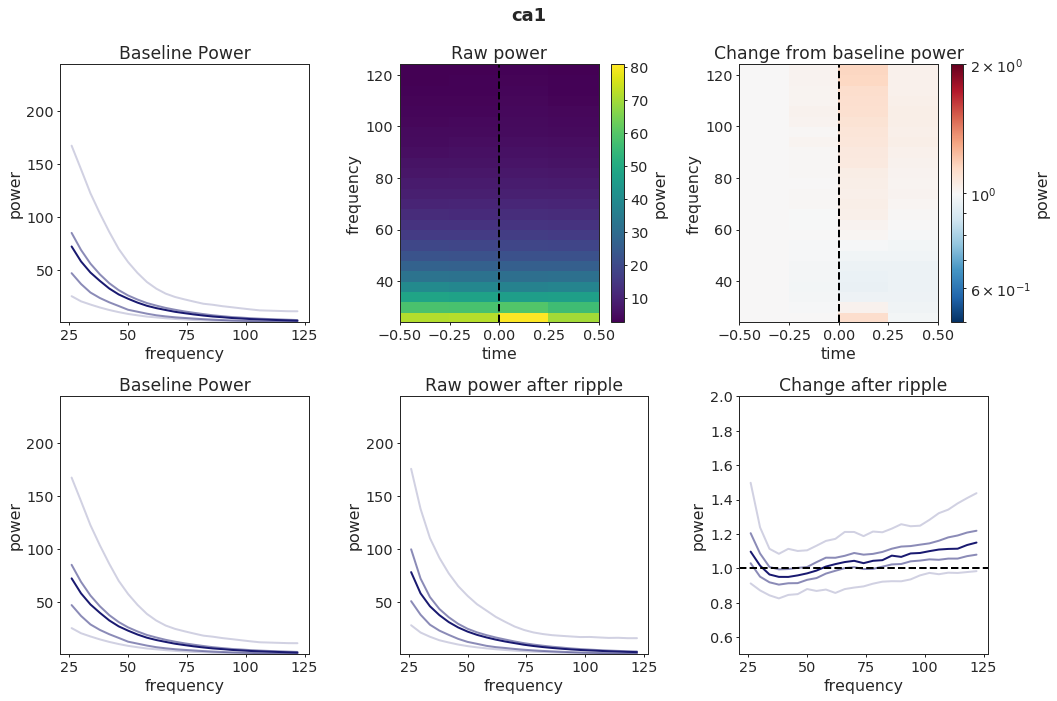

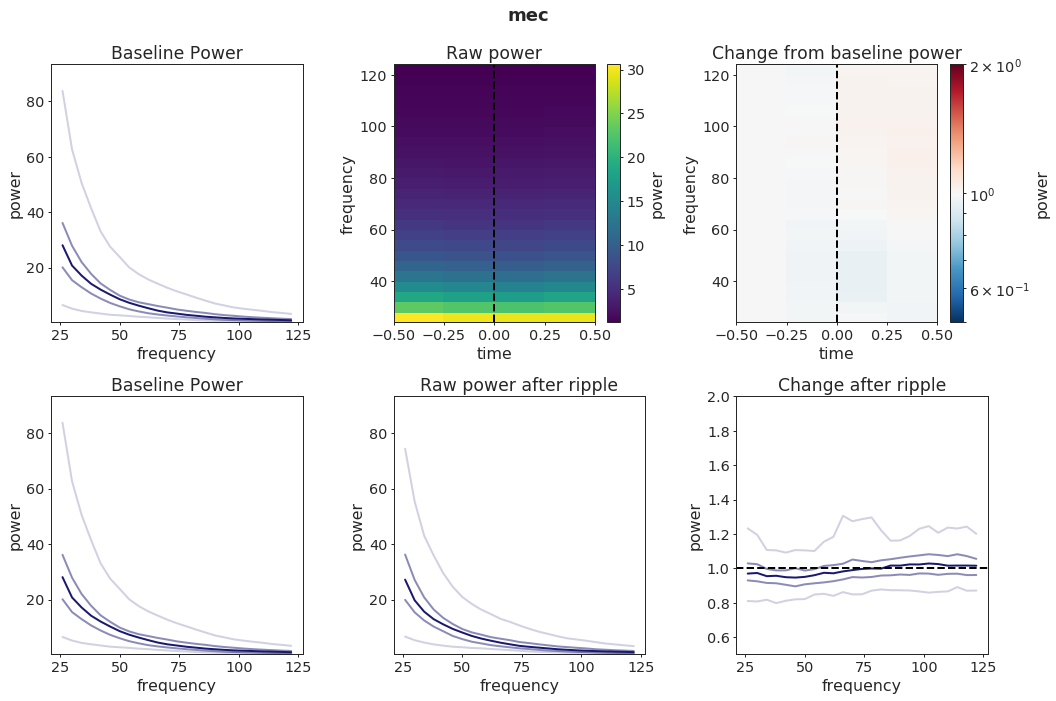

In [5]:
frequency = slice(25, 125)
path = '../Processed-Data/*.nc'
group = '12Hz_Resolution/all_ripples/power'
brain_areas = ['ca1', 'mec']

for brain_area in brain_areas:
    plot_power(path, group, brain_area, frequency=frequency)

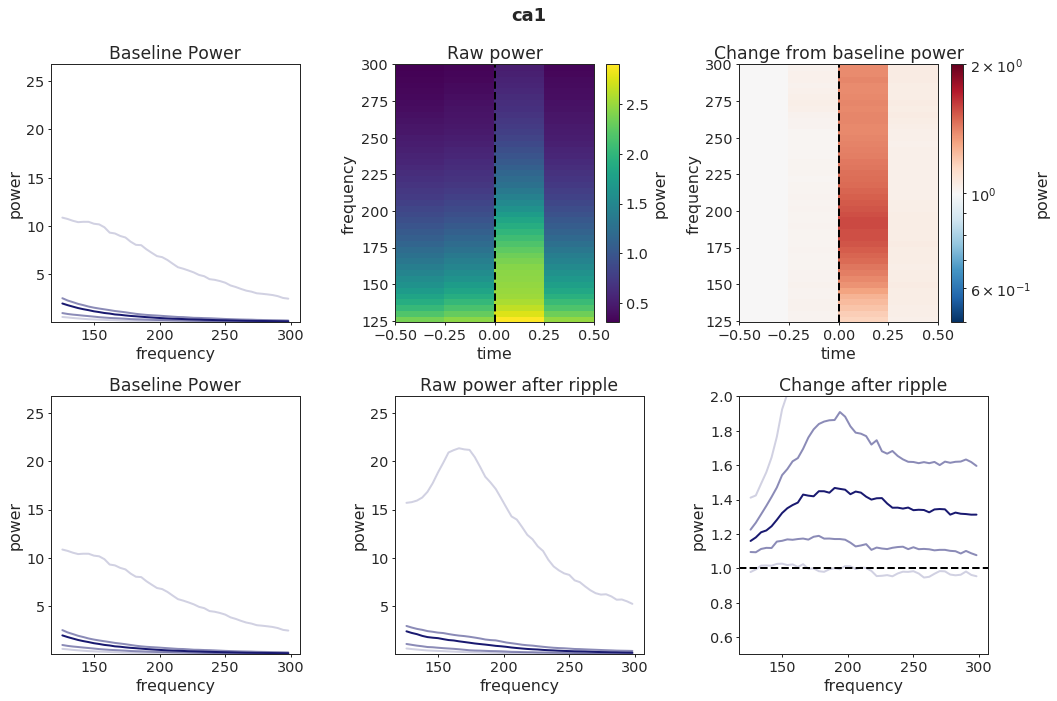

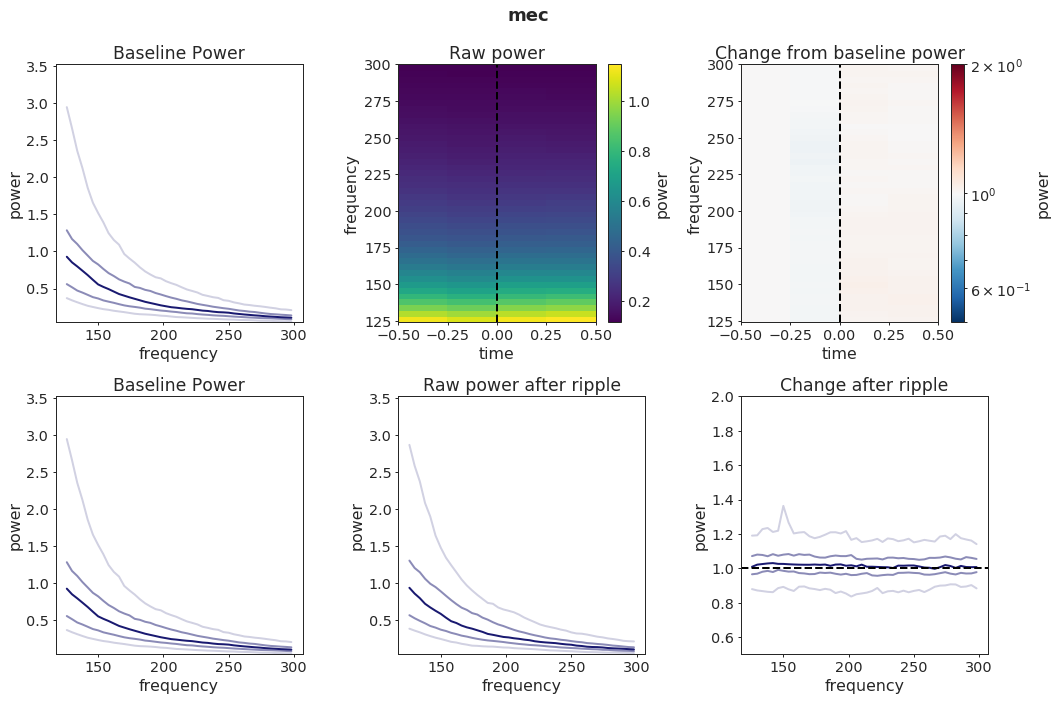

In [4]:
frequency = slice(125, 300)
path = '../Processed-Data/*.nc'
group = '12Hz_Resolution/all_ripples/power'
brain_areas = ['ca1', 'mec']

for brain_area in brain_areas:
    plot_power(path, group, brain_area, frequency=frequency)

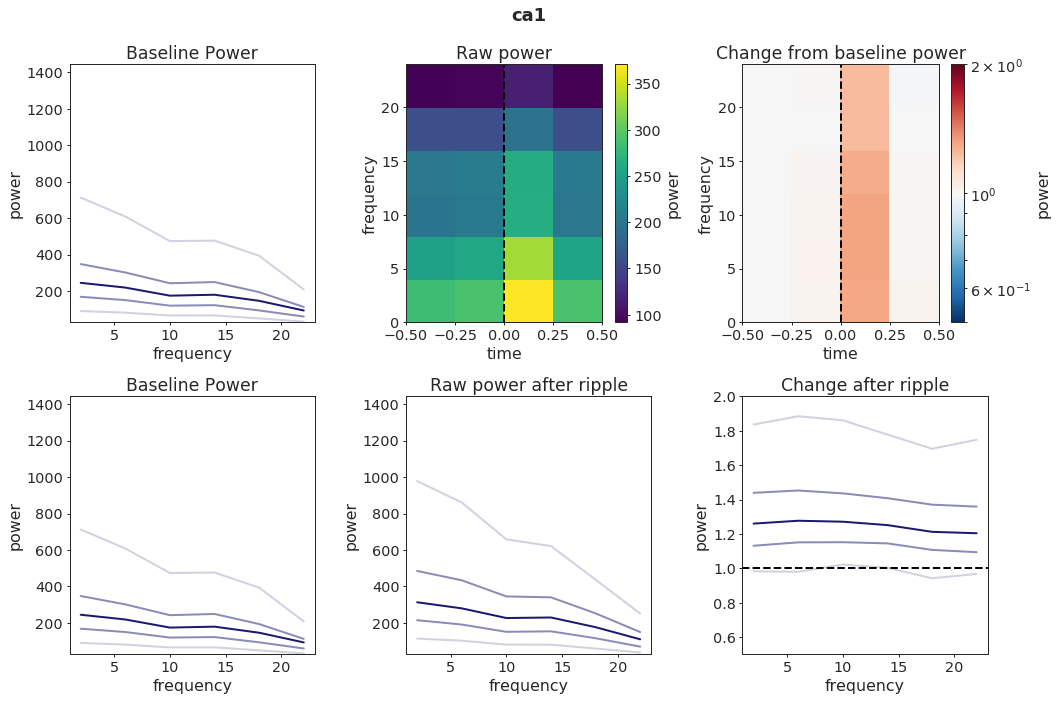

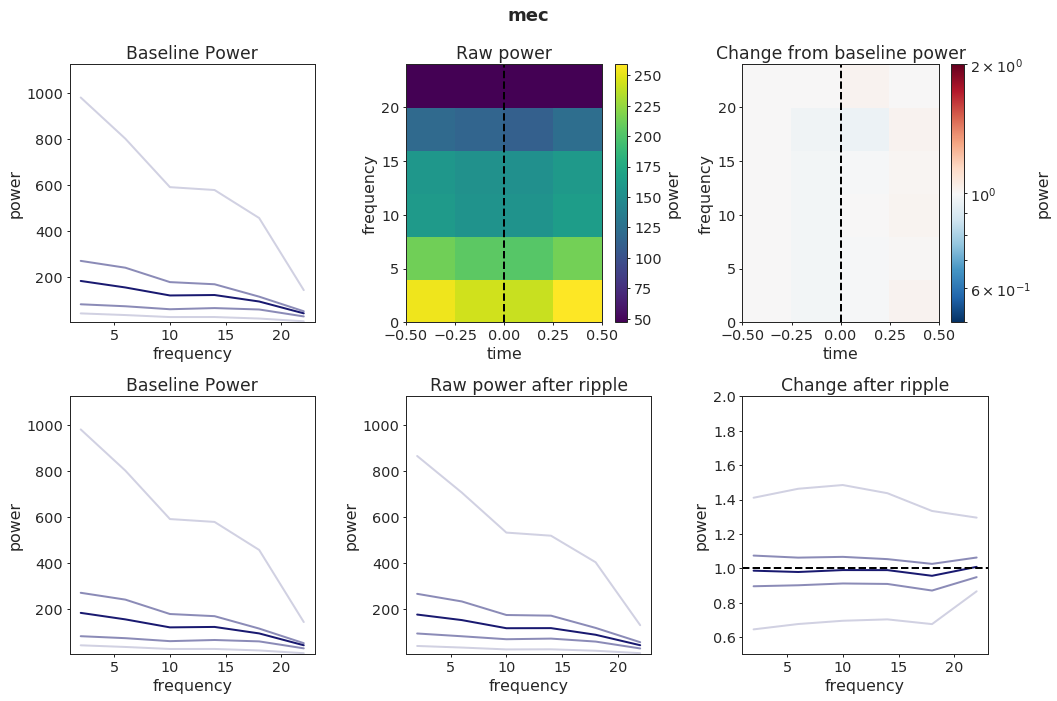

In [6]:
frequency = slice(0, 25)
path = '../Processed-Data/*.nc'
group = '12Hz_Resolution/all_ripples/power'
brain_areas = ['ca1', 'mec']

for brain_area in brain_areas:
    plot_power(path, group, brain_area, frequency=frequency)

In [18]:
def plot_connectivity(
    path, brain_area_pair, frequency, resolution, covariate,
    level1, level2=None, figsize=(15, 10),
        connectivity_measure='coherence_magnitude'):

    def get_data(level):
        group = (
            '/'.join([resolution, covariate, level, connectivity_measure])
            .replace('//', '/'))

        def _preprocess(ds):
            return ds.sel(
                tetrode1=ds.tetrode1[ds.brain_area1 == brain_area_pair[0]],
                tetrode2=ds.tetrode2[ds.brain_area2 == brain_area_pair[1]],
                frequency=frequency
            )
        return xr.open_mfdataset(
            path, concat_dim='session', group=group,
            preprocess=_preprocess, autoclose=True)[connectivity_measure].compute()

    DIMS = ['session', 'tetrode1', 'tetrode2']
    try:
        ds1 = get_data(level1)
    except ValueError:
        return
    if level2 is not None:
        ds2 = get_data(level2)
    else:
        ds2 = ds1.isel(time=0)
        
    max_value = np.max((ds1.max(), ds2.max()))
    min_value = np.min((ds1.min(), ds2.min()))

    fig, axes = plt.subplots(2, 3, figsize=figsize)

    ds1.mean(DIMS).plot(
        x='time', y='frequency', ax=axes[0, 1], cmap='Greens')
    axes[0, 1].set_title(level1)

    _plot_distribution(
        ds1.sel(time=0.0, method='backfill'), dims=DIMS, ax=axes[1, 1],
        color='green')
    axes[1, 1].set_title('{level} after ripple'.format(level=level1))
    
    axes[1, 1].set_ylim((min_value, max_value))

    if level2 is not None:
        ds2.mean(DIMS).plot(
            x='time', y='frequency', ax=axes[0, 0], cmap='Purples')
        axes[0, 0].set_title(level2)
        _plot_distribution(ds2.sel(time=0.0, method='backfill'),
                           dims=DIMS, ax=axes[1, 0], color='purple')
        axes[1, 0].set_title('{level} after ripple'.format(level=level2))
    else:
        _plot_distribution(ds2, dims=DIMS, ax=axes[0, 0], color='purple')
        axes[0, 0].set_title('Baseline')
        axes[0, 0].set_ylim((min_value, max_value))
        _plot_distribution(ds2, dims=DIMS, ax=axes[1, 0], color='purple')
        axes[1, 0].set_title('Baseline')
        axes[1, 0].set_ylim((min_value, max_value))

    ds_change = (ds1 - ds2).mean(DIMS)
    ds_change.plot(
        x='time', y='frequency', ax=axes[0, 2], cmap='PRGn', center=0)
    axes[0, 2].set_title(
        '{covariate}: {level1} - {level2}'.format(
            level1=level1, level2=level2, covariate=covariate)
    )

    _plot_distribution(
        (ds1 - ds2).sel(time=0.0, method='backfill'), dims=DIMS,
        ax=axes[1, 2], color='midnightblue')
    axes[1, 2].set_title('Change after ripple')
    axes[1, 2].set_ylim(((ds1 - ds2).min(), (ds1 - ds2).max()))
    
    axes[0, 1].axvline(0, color='black', linestyle='--')
    axes[0, 2].axvline(0, color='black', linestyle='--')
    axes[1, 2].axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.suptitle(
        '{brain_area1}-{brain_area2}'.format(
            brain_area1=brain_area_pair[0],
            brain_area2=brain_area_pair[1]),
        fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.90)

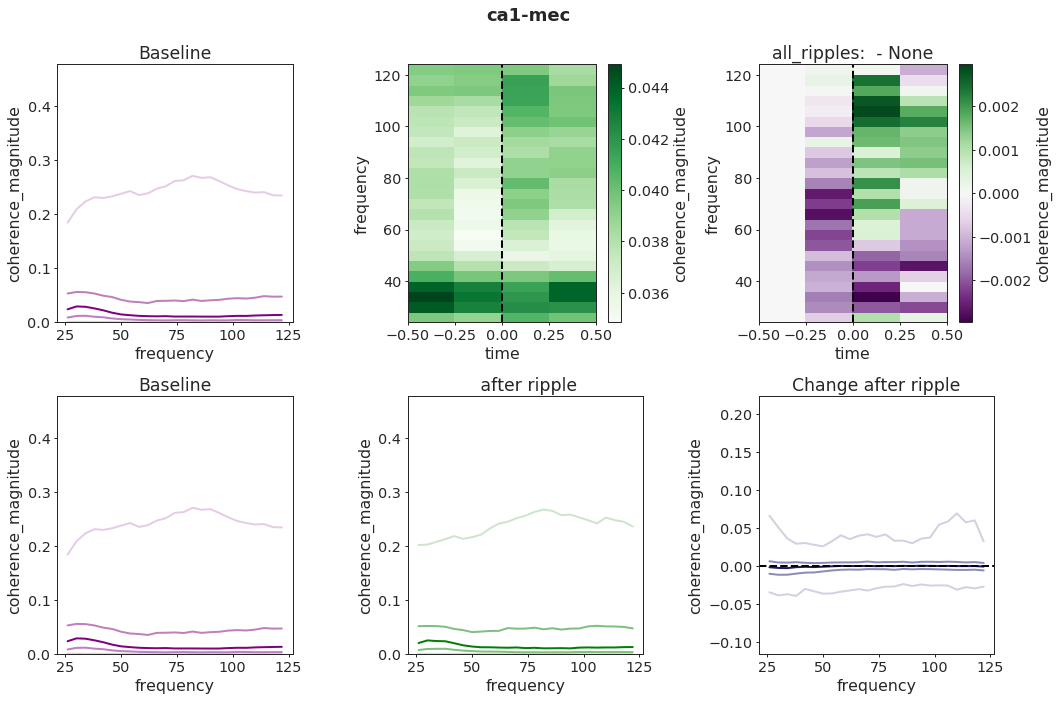

In [19]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(25, 125)

for brain_area_pair in combinations(brain_areas, 2):
    plot_connectivity(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2, figsize=(15, 10), connectivity_measure='coherence_magnitude')

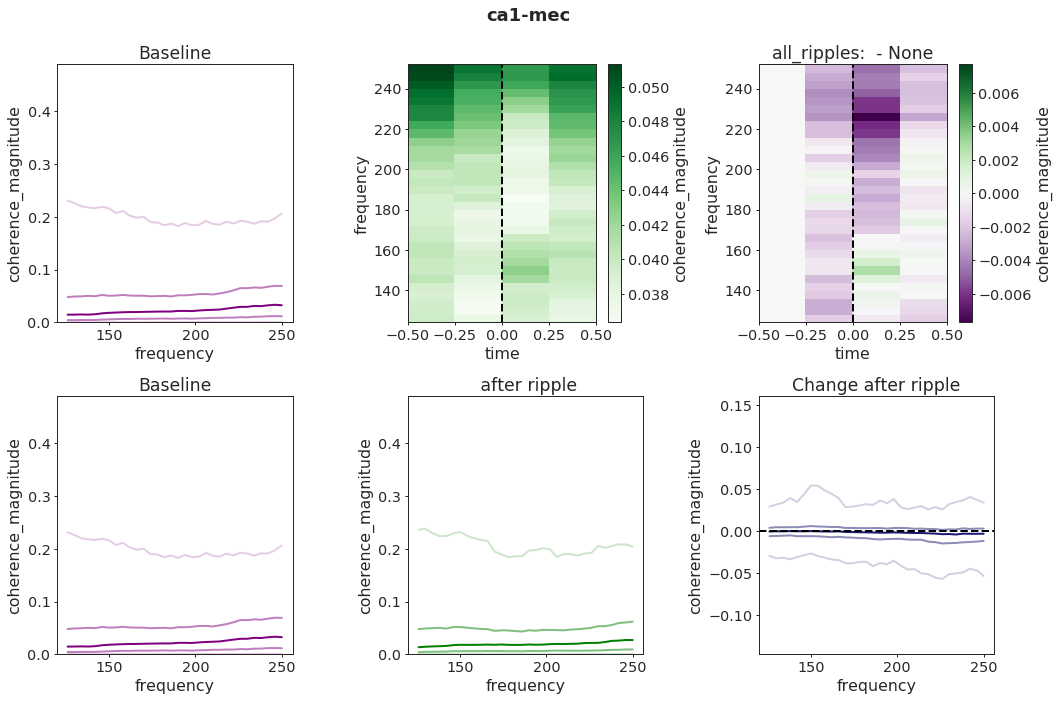

In [20]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(125, 250)

for brain_area_pair in combinations(brain_areas, 2):
    plot_connectivity(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2, figsize=(15, 10), connectivity_measure='coherence_magnitude')

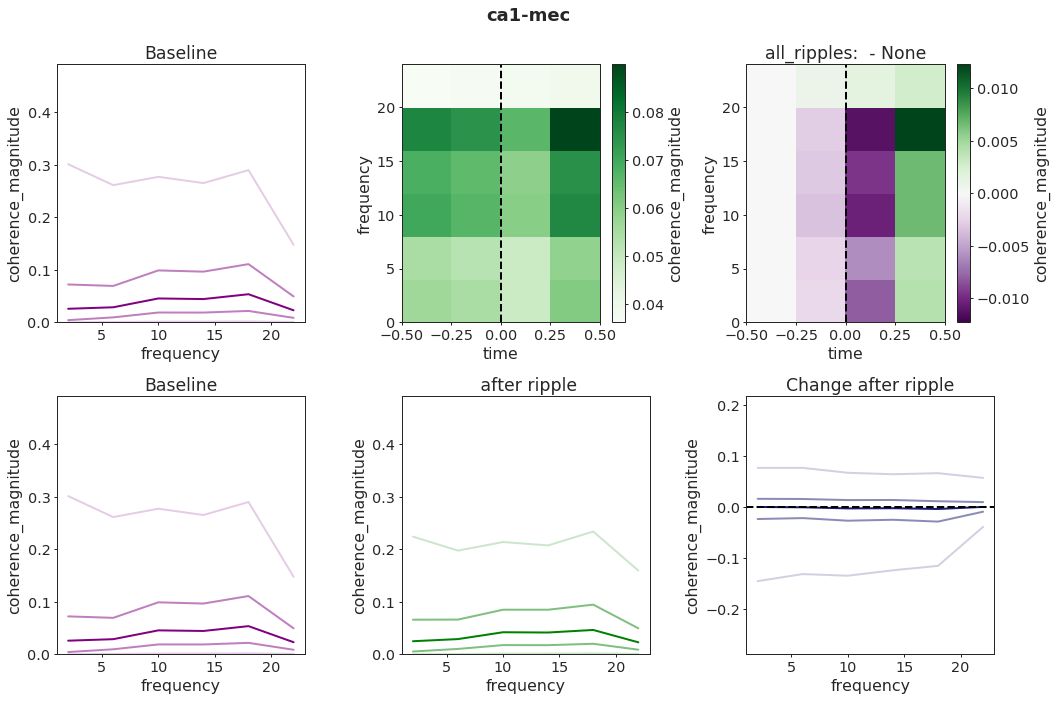

In [21]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(0, 25)

for brain_area_pair in combinations(brain_areas, 2):
    plot_connectivity(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2, figsize=(15, 10), connectivity_measure='coherence_magnitude')

In [31]:
def plot_canonical_coherence(path, brain_area_pair, frequency, resolution,
                             covariate, level1, level2=None,
                             figsize=(15, 10)):

    def get_data(level):
        group = (
            '/'.join([resolution, covariate, level, 'canonical_coherence'])
            .replace('//', '/'))
        return xr.open_mfdataset(
            path, concat_dim='session', group=group, autoclose=True).sel(
            brain_area1=brain_area_pair[0],
            brain_area2=brain_area_pair[1],
            frequency=frequency
        ).canonical_coherence.compute()

    DIMS = 'session'
    try:
        ds1 = get_data(level1)
    except (ValueError, KeyError):
        return
    if level2 is not None:
        ds2 = get_data(level2)
    else:
        ds2 = ds1.isel(time=0)

    fig, axes = plt.subplots(2, 3, figsize=figsize)

    ds1.mean(DIMS).plot(
        x='time', y='frequency', ax=axes[0, 1], cmap='Greens')
    axes[0, 1].set_title(level1)

    _plot_distribution(
        ds1.sel(time=0.0, method='backfill'), dims=DIMS, ax=axes[1, 1],
        color='green')
    axes[1, 1].set_title('{level} after ripple'.format(level=level1))
    axes[1, 1].set_ylim((0, 1))

    if level2 is not None:
        ds2.mean(DIMS).plot(
            x='time', y='frequency', ax=axes[0, 0], cmap='Purples')
        axes[0, 0].set_title(level2)
        _plot_distribution(ds2.sel(time=0.0, method='backfill'),
                           dims=DIMS, ax=axes[1, 0], color='purple')
        axes[1, 0].set_title('{level} after ripple'.format(level=level2))
        axes[1, 0].set_ylim((0, 1))
    else:
        _plot_distribution(ds2, dims=DIMS, ax=axes[0, 0], color='purple')
        axes[0, 0].set_title('Baseline')
        axes[0, 0].set_ylim((0, 1))
        _plot_distribution(ds2, dims=DIMS, ax=axes[1, 0], color='purple')
        axes[1, 0].set_title('Baseline')
        axes[1, 0].set_ylim((0, 1))

    ds_change = (ds1 - ds2).mean(DIMS)
    ds_change.plot(
        x='time', y='frequency', ax=axes[0, 2], cmap='PRGn', center=0)
    axes[0, 2].set_title(
        '{covariate}: {level1} - {level2}'.format(
            level1=level1, level2=level2, covariate=covariate)
    )

    _plot_distribution(
        (ds1 - ds2).sel(time=0.0, method='backfill'), dims=DIMS,
        ax=axes[1, 2], color='midnightblue')
    axes[1, 2].set_title('Change after ripple')
    axes[1, 2].set_ylim(((ds1 - ds2).min(), (ds1 - ds2).max()))

    axes[0, 1].axvline(0, color='black', linestyle='--')
    axes[0, 2].axvline(0, color='black', linestyle='--')
    axes[1, 2].axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.suptitle(
        '{brain_area1}-{brain_area2}'.format(
            brain_area1=brain_area_pair[0],
            brain_area2=brain_area_pair[1]),
        fontsize=18, fontweight='bold')
    plt.subplots_adjust(top=0.90)

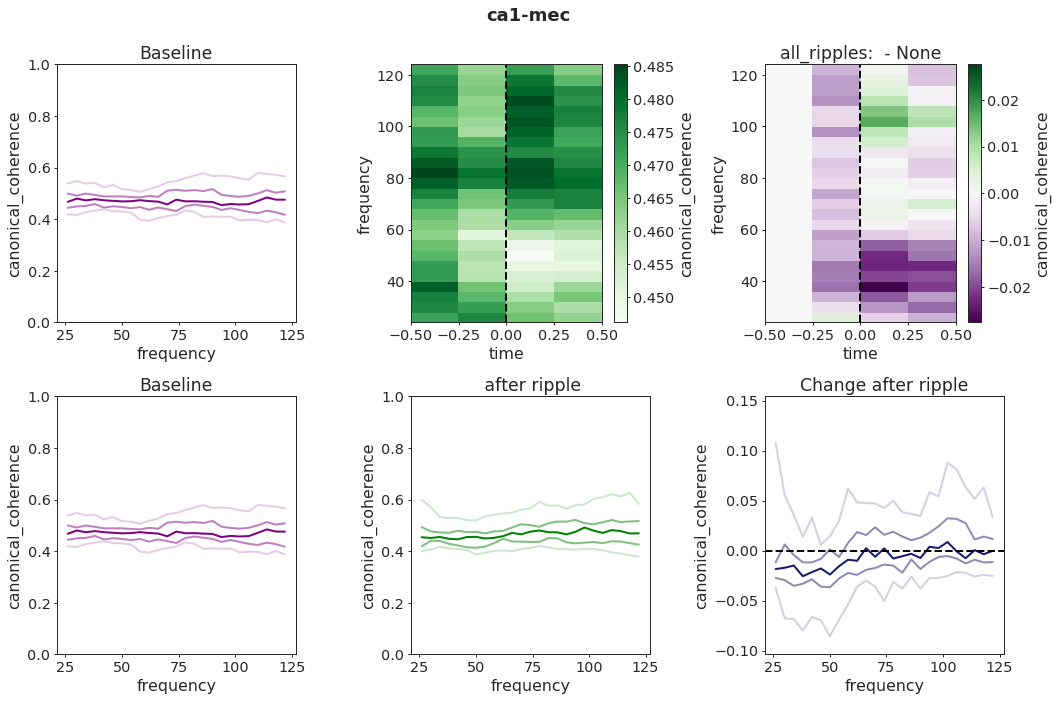

In [33]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(25, 125)

for brain_area_pair in combinations(brain_areas, 2):
    plot_canonical_coherence(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2)

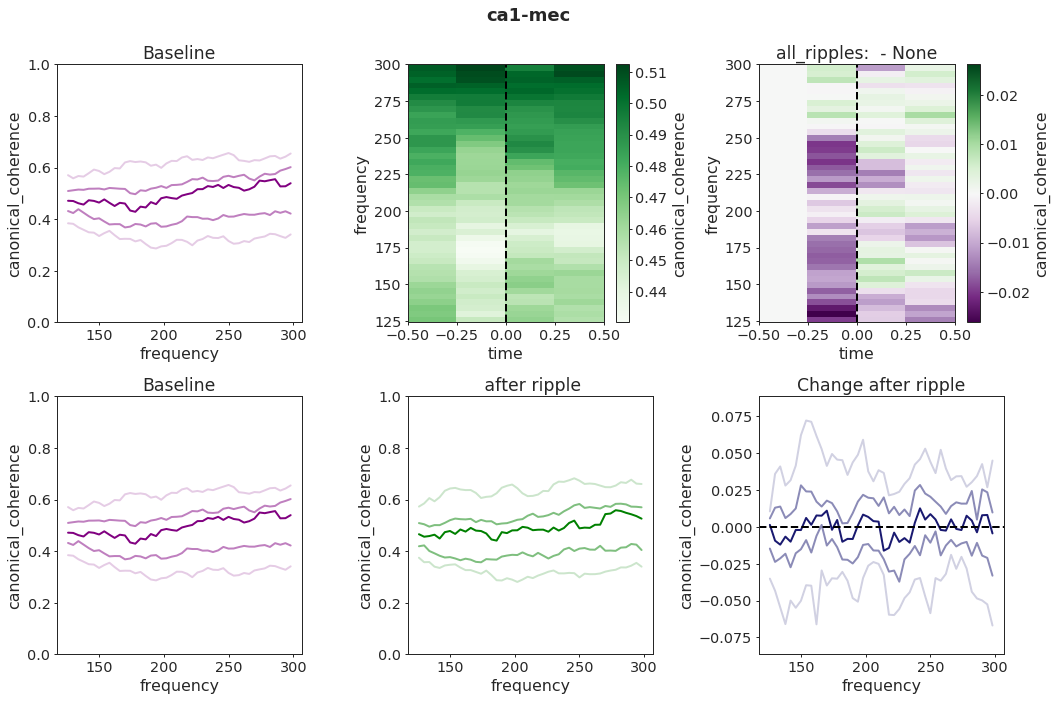

In [34]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(125, 300)

for brain_area_pair in combinations(brain_areas, 2):
    plot_canonical_coherence(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2)

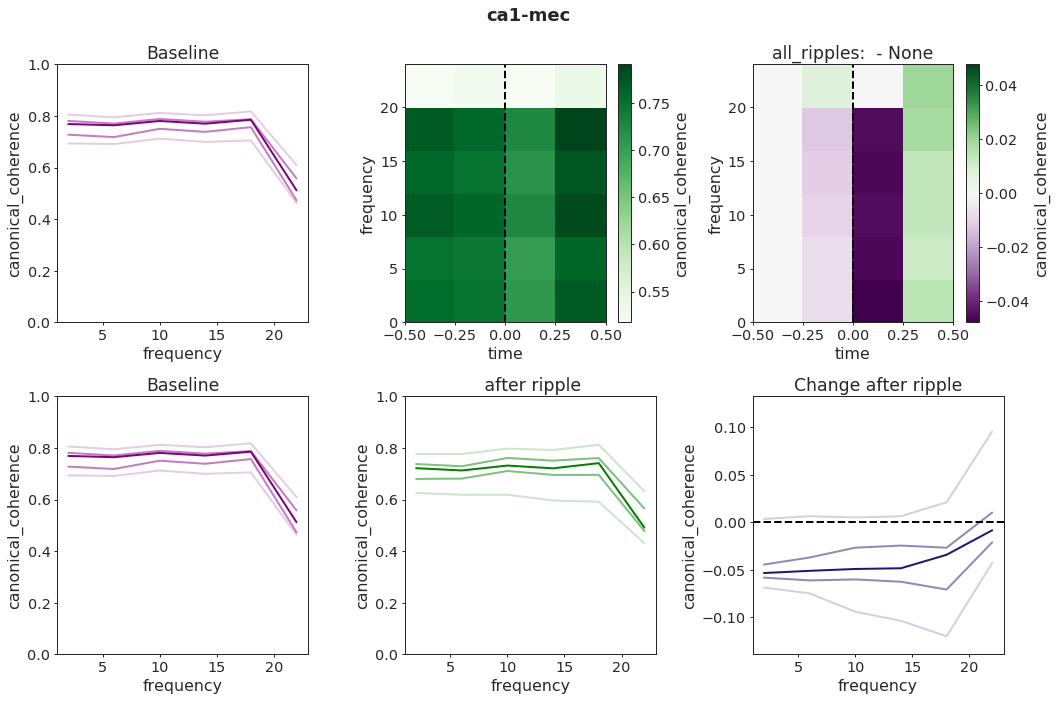

In [32]:
from itertools import combinations

brain_areas = ['ca1', 'mec']

covariate = 'all_ripples'
level1 = ''
level2 = None
resolution = '12Hz_Resolution'
frequency = slice(0, 25)

for brain_area_pair in combinations(brain_areas, 2):
    plot_canonical_coherence(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2)

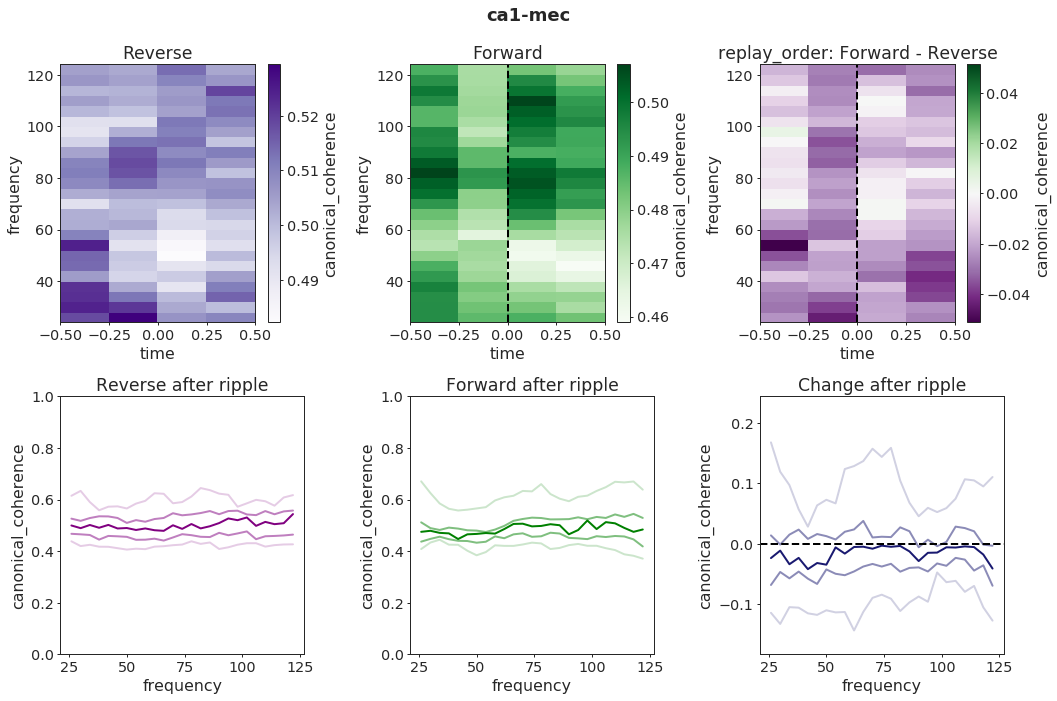

In [39]:
covariate = 'replay_order'
level1 = 'Forward'
level2 = 'Reverse'
resolution = '12Hz_Resolution'
frequency = slice(25, 125)

for brain_area_pair in combinations(brain_areas, 2):
    plot_canonical_coherence(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2)

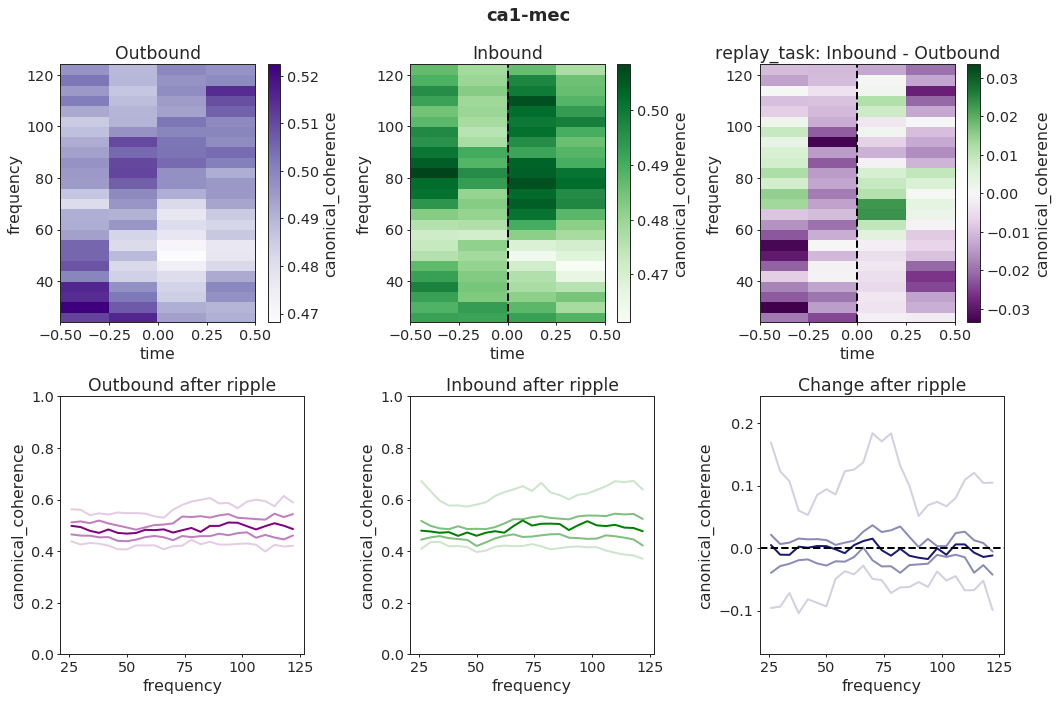

In [38]:
covariate = 'replay_task'
level1 = 'Inbound'
level2 = 'Outbound'
resolution = '12Hz_Resolution'
frequency = slice(25, 125)

for brain_area_pair in combinations(brain_areas, 2):
    plot_canonical_coherence(
        path, brain_area_pair, frequency, resolution, covariate,
        level1, level2=level2)